In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
             model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", output_attentions=True
)

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
classifier(sequence_to_classify, candidate_labels)
#{'labels': ['travel', 'dancing', 'cooking'],
# 'scores': [0.9938651323318481, 0.0032737774308770895, 0.002861034357920289],
# 'sequence': 'one day I will see the world'}

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': 'one day I will see the world',
 'labels': ['travel', 'dancing', 'cooking'],
 'scores': [0.9663747549057007, 0.01744385063648224, 0.01618141308426857]}

In [4]:
example_text = "This is an example text about snowflakes in the summer"
labels = ["weather","sports"]
classifier(example_text, labels)

{'sequence': 'This is an example text about snowflakes in the summer',
 'labels': ['weather', 'sports'],
 'scores': [0.9964873194694519, 0.0035127231385558844]}

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)


In [7]:
from bertviz import model_view

input_text = "Angela Merkel is a politician in Germany and leader of the CDU"  
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
print("num layers", len(attention)) 
final_layer_attn = attention[-1]
print(final_layer_attn.shape) # batch_size, num_heads, sequence_length, sequence_length




num layers 12
torch.Size([1, 12, 14, 14])


In [8]:
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
print(inputs[0])
model_view(attention, tokens)  # Display model view

tensor([    1, 11462, 19558,   269,   266, 11554,   267,  2439,   263,  1893,
          265,   262, 78021,     2])


<IPython.core.display.Javascript object>

torch.Size([14, 14])


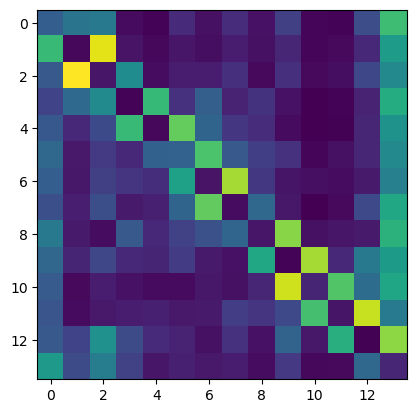

In [10]:
import matplotlib.pyplot as plt
maxA = torch.max(final_layer_attn,dim=1)[0].squeeze()
print(maxA.shape)
plt.imshow(maxA.cpu().detach().numpy())

In [11]:
#!pip install transformers[sentencepiece]
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")
sequence_to_classify = "Angela Merkel is a politician in Germany and leader of the CDU"
candidate_labels = ["politics", "economy", "entertainment", "environment"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': 'Angela Merkel is a politician in Germany and leader of the CDU', 'labels': ['politics', 'economy', 'environment', 'entertainment'], 'scores': [0.982321560382843, 0.007280206773430109, 0.005891880486160517, 0.004506284836679697]}


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.to(device)

premise = "Angela Merkel is a politician in Germany and leader of the CDU"
hypothesis = "this sentence is about politics"

input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"


prediction = torch.softmax(output["logits"][0], -1).tolist()
label_names = ["entailment", "neutral", "contradiction"]
prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print(prediction)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'entailment': 93.5, 'neutral': 6.3, 'contradiction': 0.2}


tensor([[    1, 11462, 19558,   269,   266, 11554,   267,  2439,   263,  1893,
           265,   262, 78021,     2,   291,  4378,   269,   314,  3252,     2]])
torch.Size([1, 12, 20, 20])
torch.Size([20, 20])


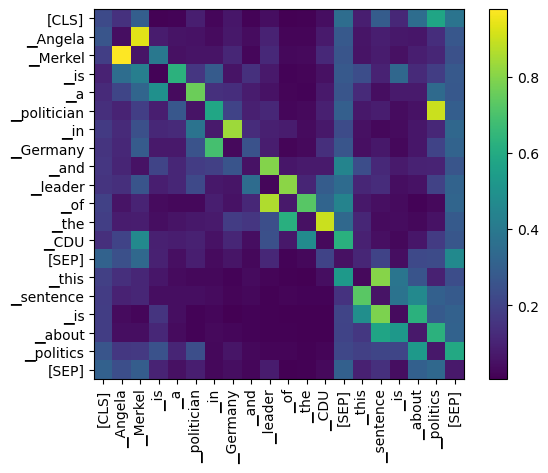

In [24]:
print(input["input_ids"])
tokens = tokenizer.convert_ids_to_tokens(input["input_ids"][0])  # Convert input ids to token strings

print(output["attentions"][-1].shape)
A = output["attentions"][-1]
maxA = torch.max(A,dim=1)[0].squeeze()
print(maxA.shape)
plt.figure()
plt.imshow(maxA.cpu().detach().numpy())
plt.xticks(list(range(len(tokens))), tokens, rotation=90)
plt.yticks(list(range(len(tokens))), tokens)
plt.colorbar()
plt.show()

In [25]:
print(input["input_ids"])
tokens = tokenizer.convert_ids_to_tokens(input["input_ids"][0])  # Convert input ids to token strings
print(tokens)
print(len(tokens))

print(A.shape)
# model_view(A, tokens)  # Display model view

tensor([[    1, 11462, 19558,   269,   266, 11554,   267,  2439,   263,  1893,
           265,   262, 78021,     2,   291,  4378,   269,   314,  3252,     2]])
['[CLS]', '▁Angela', '▁Merkel', '▁is', '▁a', '▁politician', '▁in', '▁Germany', '▁and', '▁leader', '▁of', '▁the', '▁CDU', '[SEP]', '▁this', '▁sentence', '▁is', '▁about', '▁politics', '[SEP]']
20
torch.Size([1, 12, 20, 20])


In [36]:
from text_baselines import deberta_attn
attn = deberta_attn(premise)
print(attn)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0.89870167


In [39]:
from text_baselines import deberta_NLI
entailment = deberta_NLI(premise)
print(entailment)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0.935134768486023


In [48]:
from text_baselines import deberta_zsc
prob = deberta_zsc(premise, mode="bin")
print(prob)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0.9719915986061096


In [87]:
from text_baselines import deberta_shapZSC
v = deberta_shapZSC(premise)
print(v)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.














PartitionExplainer explainer: 2it [00:12, 12.76s/it]               

0.4267420247197151


below is too slow

In [85]:
# from text_baselines import deberta_shapNLI
# v = deberta_shapNLI(premise)
# print(v)

## shap

In [16]:
pred = pipeline(
    "zero-shot-classification",
    model=model_name,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

In [18]:
import shap
explainer = shap.Explainer(pred)

In [22]:
explainer

In [97]:
# import pandas as pd
# sequence_to_classify = "one day I will see the world"
# candidate_labels = ['travel', 'cooking']

# data = pd.DataFrame({"text": sequence_to_classify, "label":candidate_labels})

# data.head()

In [92]:
import shap
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline
from typing import Union, List

weights = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
model = AutoModelForSequenceClassification.from_pretrained(weights, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(weights)

# Create your own pipeline that only requires the text parameter 
# for the __call__ method and provides a method to set the labels
class MyZeroShotClassificationPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    def __call__(self, *args):
      o = super().__call__(args[0], self.workaround_labels)[0]

      return [[{"label":x[0], "score": x[1]}  for x in zip(o["labels"], o["scores"])]]

    def set_labels_workaround(self, labels: Union[str,List[str]]):
      self.workaround_labels = labels

example_text = "This is an example text about snowflakes in the summer"
labels = ["weather","sports"]

# In the following, we address issue 2.
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

pipe = MyZeroShotClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipe.set_labels_workaround(labels)


In [94]:
def score_and_visualize(text):
    prediction = pipe([text])
    print(prediction[0])

    explainer = shap.Explainer(pipe)
    shap_values = explainer([text])
    print(shap_values)

    shap.plots.text(shap_values)

score_and_visualize(example_text)


[{'label': 'weather', 'score': 0.9964873194694519}, {'label': 'sports', 'score': 0.0035127231385558844}]


PartitionExplainer explainer: 2it [00:10, 10.30s/it]               


.values =
array([[[ 0.51006745,  0.05243254,  0.        ],
        [ 0.10225558, -0.03975558,  0.        ],
        [ 0.13216399, -0.06966399,  0.        ],
        [-0.11636066, -0.07113935,  0.        ],
        [ 0.16413648, -0.03913648,  0.        ],
        [-0.08446479, -0.04053521,  0.        ],
        [ 0.14995419,  0.03754581,  0.        ],
        [-0.0702825 , -0.1172175 ,  0.        ],
        [ 0.1973508 , -0.07235079,  0.        ],
        [-0.05172822, -0.07327176,  0.        ],
        [-0.05161761, -0.07338237,  0.        ],
        [-0.30073944, -0.07426055,  0.        ]]])

.base_values =
array([[0.41575205, 0.58424795, 0.        ]])

.data =
(array(['', 'This', ' is', ' an', ' example', ' text', ' about',
       ' snowflakes', ' in', ' the', ' summer', ''], dtype=object),)


In [105]:
from text_baselines import deberta_shapZSC, deberta_shapNLI
deberta_shapNLI("The most apparent symptom of pneumonic plague is coughing, often with hemoptysis")

[autoreload of torch.overrides failed: Traceback (most recent call last):
  File "/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/torch/overrides.py", line 1512, in <module>
    has_torch_function = _add_docstr(
RuntimeError: function '_has_torch_function' already has a d

: 

: 

In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [ ]:
import torch
import json
import numpy as np
import os

: 

In [15]:
test = "/dfs/scratch1/gmachi/datasets/WikiSection/wikisection_en_disease_test.json"
with open(test, 'r') as f:
    test_data = json.load(f)

save_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/"
save_path_attn = os.path.join(save_path, "attn_Gs")
save_path_entail = os.path.join(save_path, "entail_Gs")
# save_path_prob = os.path.join(save_path, "prob_Gs")

# save_path_shap = os.path.join(save_path, "shap_Gs")

target = "disease.genetics"  # class-1

In [16]:
from utils import process_sentences
from utils import serialize, deserialize
from utils import convert_text2graph
import random
import networkx as nx

In [24]:
def process_Zs_scores_parallel(test_data, score_fn, save_path_G1s, save_path_G2s):
    section_labs = {}
    section_pseudo = {}
    doc_labs = {}
    sal_count = 0
    for i in range(len(test_data)):
        G_file = "doc_"+str(i) + "_graph.obj"
        save_path_G1 = os.path.join(save_path_G1s, G_file)
        save_path_G2 = os.path.join(save_path_G2s, G_file)

        if os.path.isfile(save_path_G1) and os.path.isfile(save_path_G2):
            print("skipping sample bc already created (for both):", G_file)
            continue

        text = test_data[i]["text"]
        annots = test_data[i]["annotations"]
        labs = []
        pseudos = []
        scores1 = []
        scores2 = []

        num_sents = 0
        for annot in annots:
            begin = int(annot["begin"])
            idx = [begin, begin+int(annot["length"])]
            chunk = text[idx[0]:idx[1]]
            sents = [s for s in chunk.split(".")]
            sents = process_sentences(sents)

            # get score for sentence
            es = [score_fn(s) for s in sents]
            scores1.extend([[el[0]] for el in es])
            scores2.extend([[el[1]] for el in es])

            ns = len(sents)
            num_sents += ns
            pseudo = [annot["sectionLabel"]] * ns
            pseudos.extend(pseudo)

            lab = [0] * ns
            if pseudo[0] == target: # if any match
                lab = [1] * ns
            labs.extend(lab)
        
        print("sentences in doc:", num_sents)
        sal_count += int(np.sum(labs)) # keep count of targets
        doc_lab = int(np.sum(labs) > 0)
        doc_labs[i] = doc_lab
        
        Z1 = np.array(scores1) # attn
        Z2 = np.array(scores2) # entail
        # save straight as graph
        G1 = convert_text2graph(Z1)
        G2 = convert_text2graph(Z2)
        serialize(G1, save_path_G1)
        serialize(G2, save_path_G2)

        section_pseudo[i] = pseudos
        section_labs[i] = labs

    return section_labs, section_pseudo, doc_labs, sal_count

In [25]:
from text_baselines import deberta_attn_NLI
process_Zs_scores_parallel(test_data, deberta_attn_NLI, save_path_attn, save_path_entail)

skipping sample bc already created (for both): doc_0_graph.obj


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

sentences in doc: 62


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to tru

KeyboardInterrupt: 